In [41]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [42]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const angstrom2au = 1.8897268777744 # Not sure if this is the correct units for length
const au2cm = 5.29e-9

5.29e-9

In [43]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [44]:
σ = 10*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [45]:
function discretize(sd::fitsd, num_osc::Int)
    return sd.ωs, (sd.jws.^(0.5))
end

discretize (generic function with 1 method)

In [46]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

Ordejon paper mentions that Hamiltonian electronic terms are $\epsilon_0$ , $\epsilon_{AA+b}$ and $\epsilon_{AA+2b}$ for nearest 2 neighbours and additionally mentions that the coupling terms for nearest 2 neighbours on either side. Further mentions the couplings $\epsilon$AB, AC, AD for neighbours on the same unit cell. However, the value for $\epsilon_0$ (site energies) isn't mentioned in the paper? Perhaps worth doing some TD-DFT ourselves? Or alternatively some TrESP-ish method for 1-D... have to think about this for a bit

In [47]:
ϵ0 = -5000 * mev2invcm # This appears to not change the dynamics at all
ϵb = 134.0
ϵ2b = -10.7


site_distance = 7.15 * angstrom2au


13.51154717608696

In [48]:
N = 10

10

In [49]:
H0 = Matrix{ComplexF64}(zeros(N, N))

10×10 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

In [50]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-2
        H0[i, i+2] = ϵ2b
    end
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
    if i>=3
        H0[i, i-2] = ϵ2b
    end
end

In [51]:
H0 = H0 * invcm2au

10×10 Matrix{ComplexF64}:
   -0.183757+0.0im  0.000610548+0.0im  …          0.0+0.0im
 0.000610548+0.0im    -0.183757+0.0im             0.0+0.0im
 -4.87527e-5+0.0im  0.000610548+0.0im             0.0+0.0im
         0.0+0.0im  -4.87527e-5+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im  …          0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im     -4.87527e-5+0.0im
         0.0+0.0im          0.0+0.0im     0.000610548+0.0im
         0.0+0.0im          0.0+0.0im       -0.183757+0.0im

In [52]:
ωp = [57.8, 59.6, 89.0, 107.3, 139.1, 639.1, 1011.2, 1344.7, 1593.3] .* invcm2au
ωpg0p = [-1.7, 1.4, 1.6, -0.14, -2.3, -7.5, -3.6, 19.8, -42.0] * invcm2au
g0p = ωpg0p ./ ωp
jws = (g0p.^(2))
wm = maximum(ωp)
Jw = fitsd(ωp, jws, wm, 1.0, false)

fitsd([0.000263355874, 0.00027155726800000003, 0.00040551337, 0.0004888942090000001, 0.000633785503, 0.002911950503, 0.004607360896, 0.006126896951000001, 0.007259600589], [0.0008650519031141869, 0.00055177694698437, 0.0003231915162226992, 1.7023804664001344e-6, 0.0002734018267790112, 0.00013771615591192445, 1.2674501281845861e-5, 0.00021681013046385349, 0.0006948698503452422], 0.007259600589, 1.0, false)

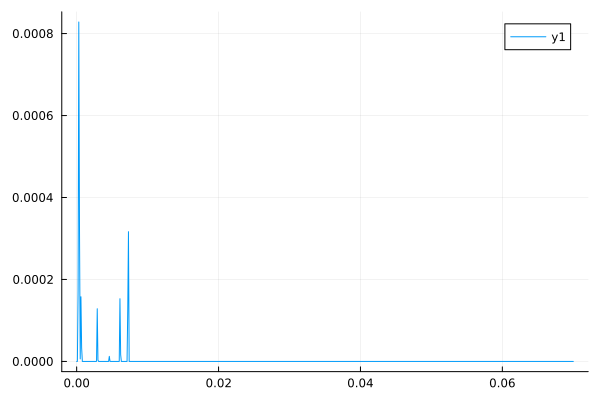

In [13]:
ω = 0:0.0001:0.07
plot(ω, Jw.(ω))

In [24]:
nsteps = 500
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[5, 5] = 1

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [18]:
dt = 20.0 # Around 0.5fs

20.0

In [19]:
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

(0.0:20.0:10000.0, [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 2.303261998813023e-13 + 0.0im -5.6702674178479476e-12 + 7.187174600475288e-13im … 2.3031774326878857e-13 + 9.416296601927159e-19im -2.807265933936896e-16 - 2.774029487765818e-15im; … ; 0.001903038453099433 - 0.0036966538735366083im 0.024692905201797625 + 0.005432292267048043im … 0.0026211931796903294 - 0.024106027236177257im 0.02012170563307732 - 0.00038347935423328256im; 0.002188310660573782 - 0.0036305728209482433im 0.024754179470399786 + 0.0075132247233452056im … 0.0036353498704696217 - 0.025066311620601422im 0.020027712449721024 + 0.0008243497009102242im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -5.6700314711763555e-12 - 7.186875533464833e-13im 1.418357416313071e-10 + 0.0im … -5.670056291106373e-12 - 7.187142531909707e-13im -1.7451274405927364e-15 + 6.916821504895996e-14im; … ; 0.030230222272172837 - 0.01537746679639766im 0.1579856141829058 - 0.0034974544500557345im … -0.019423552984165527 - 0.094155

In [61]:
## QCPI Run

ω, c = discretize(Jw, 100)
hb = Solvents.HarmonicBath(β, ω, c, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0], extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

LoadError: InterruptException:

HEOM only runs with Drude-Lorentz spectral densities...

In [138]:
## Running with HEOM

λs = repeat([35.0], N) * invcm2au
γs = 1 ./ (repeat([50.0], N) ./ au2fs)
JwD = Vector{SpectralDensities.DrudeLorentz}()
sys_ops = Vector{Matrix{ComplexF64}}()
for (j, (λ, γ)) in enumerate(zip(λs, γs))
    push!(JwD, SpectralDensities.DrudeLorentz(; λ, γ, Δs=1.0))
    op = zeros(N, N)
    op[j, j] = 1.0
    push!(sys_ops, op)
end

@time th, ρh = HEOM.propagate(; Hamiltonian=H0, ρ0=ρ0, Jw=JwD, β, ntimes=nsteps, dt, sys_ops, num_modes=2, Lmax=3, scaled=true, threshold=1e-10, extraargs=Utilities.DiffEqArgs(; reltol=1e-6, abstol=1e-6))

LoadError: InterruptException:

In [63]:
MSD = []
for i in 1:nsteps
    s = 0.0
    for j in 1:N
        s += real(ρ[i, j, j])*(site_distance*(j-5))^2
    end
    push!(MSD, s)
end

In [64]:
display("text/plain", MSD)

500-element Vector{Any}:
    0.0
    0.055831293331708366
    0.22332517332310545
    0.502481639940408
    0.8933006786084253
    1.395782260010231
    2.0099263397137426
    2.735732857613691
    3.573201737174279
    4.522332884454653
    5.583126186896008
    6.755581511845986
    8.039698704792535
    ⋮
 1143.40646637854
 1141.1171455715476
 1138.8900049396048
 1136.7257459027662
 1134.6250633225204
 1132.588644421699
 1130.6171677254554
 1128.711302024873
 1126.8717053647192
 1125.099024056781
 1123.3938917201754
 1121.7569283499454

In [65]:
μ = β * (MSD[nsteps] - MSD[1])/((t[nsteps] - t[1])*au2fs)

4891.106582524836

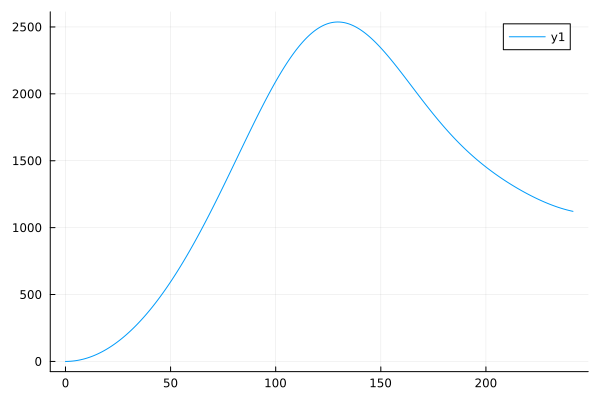

In [66]:
plot(t[1:nsteps].*au2fs, MSD, fmt= :png)

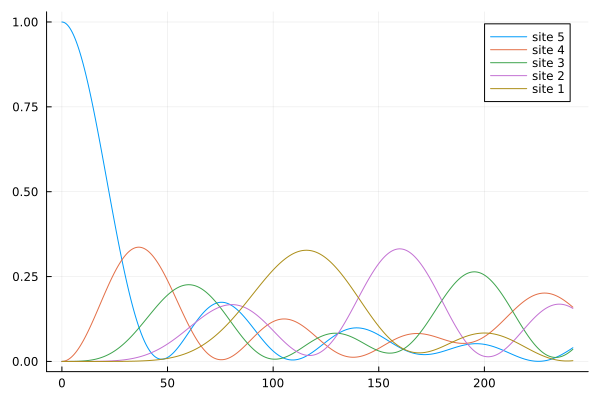

In [67]:
plot(t.*au2fs, real.(ρ[:, 5, 5]), label="site 5")
plot!(t.*au2fs, real.(ρ[:, 4, 4]), label="site 4")
plot!(t.*au2fs, real.(ρ[:, 3, 3]), label="site 3")
plot!(t.*au2fs, real.(ρ[:, 2, 2]), label="site 2")
plot!(t.*au2fs, real.(ρ[:, 1, 1]), label="site 1")

In [114]:
plot(th, real.(ρh[:, 5, 5]), label="site 5")
plot!(th, real.(ρh[:, 4, 4]), label="site 4")
plot!(th, real.(ρh[:, 3, 3]), label="site 3")
plot!(th, real.(ρh[:, 2, 2]), label="site 2")
plot!(th, real.(ρh[:, 1, 1]), label="site 1")

LoadError: UndefVarError: `th` not defined